In [111]:
%matplotlib inline

import torch
from torch import nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
from gym.envs.registration import registry, register
import random
from typing_extensions import Self
import matplotlib.pyplot as plt
from minigrid.wrappers import ObservationWrapper
import imageio

import pickle
import seaborn as sns
from dataclasses import dataclass

import pandas as pd
from torch import optim
from typing import Any
from copy import deepcopy
from collections import deque
from minigrid.wrappers import ObservationWrapper


In [112]:
MAX_FRAMES_PER_EP = 3000

In [113]:
def get_device() -> torch.device:
    """
    Returns the device to use for training.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def argmax_with_key(lst, key):
    return max(enumerate(lst), key=lambda x: key(x[1]))[0]


In [114]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class MyDoorKeyEnv(DoorKeyEnv):
    def __init__(self, size):
        self.render_mode = "rgb_array"
        super().__init__(size=size)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

class ImgObsWrapper(ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission.

    Parameters:
    - env (gym.Env): The environment to wrap.

    Methods:
    - observation(self, obs): Returns the image from the observation.
    - reset(self): Resets the environment and returns the initial observation.
    """

    def __init__(self, env):
        """
        Initializes the ImgObsWrapper with the given environment.

        Parameters:
        - env (gym.Env): The environment whose observations are to be wrapped.
        """
        super().__init__(env)
        self.observation_space = env.observation_space.spaces["image"]

    def observation(self, obs):
        """
        Extracts and returns the image data from the observation.

        Parameters:
        - obs (dict or tuple): The original observation from the environment, which could be either
        a dictionary or a tuple containing a dictionary.

        Returns:
        - np.ndarray: The image data extracted from the observation.
        """
        if type(obs) == tuple:
            return obs[0]["image"]
        return obs["image"]

    def reset(self):
        """
        Resets the environment and returns the initial observation image.

        Returns:
        - np.ndarray: The initial observation image of the reset environment.
        """
        obs = super().reset()
        return obs[0]
    
def get_door_key_env(size):
    """
    Returns a DoorKeyEnv environment with the given size.
    """
    env = MyDoorKeyEnv(size=size)
    env = ImgObsWrapper(env)

    env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    # get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
    #            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
    #            tile_size (int): How many pixels will form a tile from the NxM grid.
    #            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
    frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
    # show an image to the notebook.
    plt.imshow(frame)

    return env


In [115]:
class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                gae_lambda=0.95,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=True,
                use_gae=True,
                importance_sampling_clip=2.0,
                bad_fit_threshold=0.8,
                bad_fit_increment=None,
                replay_buffer_capacity=10,
                large_buffer_capacity=20):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.use_gae = use_gae # whether to use GAE or not.
        self.importance_sampling_clip = importance_sampling_clip # importance sampling clip threshold
        self.bad_fit_threshold = bad_fit_threshold # threshold for bad fit.
        if bad_fit_increment is None:
            bad_fit_increment = (1.0 - bad_fit_threshold) / replay_buffer_capacity
        self.bad_fit_increment = bad_fit_increment # increment for bad fit.
        self.replay_buffer_capacity = replay_buffer_capacity # capacity of replay buffer.
        self.large_buffer_capacity = large_buffer_capacity # capacity of large replay buffer.


In [116]:
class Machine:
    def __init__(self, entropy_coef, init_model:nn.Module, args:Config=None):
        """
        A Machine object consists of a Model and its entropy_coef

        Args:
            entropy_coef: Entropy coefficient.
            init_model: Initial model.
            args
        """
        if args is None:
            self.args = Config()
        else:
            self.args = args

        self.model = init_model
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.coef = entropy_coef

    def copy_model(self, other_model:nn.Module) -> None:
        """
        Copy state dict from 'model'. Reset rs.
        """
        state_dict = other_model.state_dict()
        for key, v in state_dict.items():
            if key in self.model.state_dict():
                self.model.state_dict()[key].copy_(v)

    def copy_machine(self, other:Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        self.copy_model(other.model)

    def _compute_discounted_return(self, rewards):
        """
            rewards: reward obtained at timestep.  Shape: (T,)
            discount: discount factor. float

        ----
        returns: sum of discounted rewards. Shape: (T,)
        """
        device = get_device()
        returns = torch.zeros(*rewards.shape, device=device)

        R = 0
        for t in reversed(range((rewards.shape[0]))):
            R = rewards[t] + self.args.discount * R
            returns[t] = R
        return returns

    def _compute_advantage_gae(self, values, rewards, T):
        """
        Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

        values: value at each timestep (T,)
        rewards: reward obtained at each timestep.  Shape: (T,)
        T: the number of frames, float
        gae_lambda: hyperparameter, float
        discount: discount factor, float

        -----

        returns:

        advantages : tensor.float. Shape [T,]

                    gae advantage term for timesteps 0 to T

        """
        advantages = torch.zeros_like(values)
        for i in reversed(range(T)):
            next_value = values[i+1]
            next_advantage = advantages[i+1]

            delta = rewards[i] + self.args.discount * next_value  - values[i]
            advantages[i] = delta + self.args.discount * self.args.gae_lambda * next_advantage
        return advantages[:T]
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        device = get_device()

        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=device, dtype=torch.int)
        values = torch.zeros(*shape, device=device)
        rewards = torch.zeros(*shape, device=device)
        log_probs = torch.zeros(*shape, device=device)
        obss = [None]*MAX_FRAMES_PER_EP

        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction
            with torch.no_grad():
                dist, value = self.model(obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())

            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)

            total_return += reward
            T += 1

            if done or T >= MAX_FRAMES_PER_EP-1:
                break

        success = (total_return > 0.1)
        
        discounted_reward = self._compute_discounted_return(rewards[:T])
        exps = dict(
            obs = torch.tensor(np.array(obss[:T]), device=device),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T,
            'success': success
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, dist:Categorical, factors, indices, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        policy_loss_tensor = factors * ppo_loss + self.coef * entropy

        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2

        return policy_loss, approx_kl
    
    def _compute_value_loss(self, values, returns):
        value_loss = torch.mean((values - returns) ** 2)

        return value_loss

    def update_parameters(self, sb, update_v=True):
        T = sb['T']
        with torch.no_grad():
            dist, values = self.model(sb['obs'])
        values = values.reshape(-1)
        dist: Categorical
        old_logp = dist.log_prob(sb['action'])
        init_logp = sb['log_prob']
        not_full_reward = sb['reward']

        # add 0 to end of values until it has length MAX_FRAMES_PER_EP
        values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=get_device())], dim=0)
        full_reward = torch.cat([not_full_reward, torch.zeros((MAX_FRAMES_PER_EP - len(not_full_reward), ), device=get_device())], dim=0)


        if self.args.use_gae:
            advantage = self._compute_advantage_gae(values_extended, full_reward, T)
        else:
            advantage = sb['discounted_reward'] - values.reshape(-1)

        for i in range(self.args.train_ac_iters):
            self.optim.zero_grad()
            dist, values = self.model(sb['obs'])
            values = values.reshape(-1)
            # policy loss
            factors = torch.exp(old_logp - init_logp)
            indices = factors < self.args.importance_sampling_clip
            fit = torch.mean(indices.to(torch.float32))

            loss_pi, approx_kl = self._compute_policy_loss_ppo(dist, factors, indices, old_logp, sb['action'], advantage)
            if update_v:
                loss_v = self._compute_value_loss(values, sb['discounted_reward'])
            else:
                loss_v = 0.0

            if i == 0:
                policy_loss = loss_pi
                value_loss = loss_v

            loss = loss_v + loss_pi
            if approx_kl > 1.5 * self.args.target_kl:
                break

            loss.backward(retain_graph=True)
            self.optim.step()

        update_policy_loss = policy_loss.item()
        update_value_loss = value_loss.item()

        logs = {
            "policy_loss": update_policy_loss,
            "value_loss": update_value_loss,
            "fit": fit.item()
        }

        return logs
    
    def decrease_prob(self, sb, lr=0.1) -> None:
        self.optim.zero_grad()

        dist, _ = self.model(sb['obs'])
        dist: Categorical
        logps = dist.log_prob(sb['action'])

        loss = lr * torch.mean(logps)
        loss.backward()
        self.optim.step()

    def modify_logp(self, sb) -> dict:
        """
        Modify logp and return a new sb.
        """
        with torch.no_grad():
            dist, _ = self.model(sb['obs'])
        dist: Categorical
        result = deepcopy(sb)
        result['log_prob'] = dist.log_prob(sb['action'])

        return result


In [117]:
class PPO:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The PPO agent.
        """

        self.env = env

        set_random_seed(seed)
        model = ACModelClass(use_critic=True)

        if args is None:
            args = Config()
        self.machine = Machine(0.01, model, args)

    def get_action(self, ob):
        """
        Returns:
        - action
        - probability of the action
        """
        if isinstance(ob, tuple):
            ob = ob[0]
        with torch.no_grad():
            dist, _value = self.machine.model(ob)

        dist: Categorical
        action = dist.sample()[0]
        prob = dist.log_prob(action).exp().item()

        return action, prob
    
    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float]]:
        """
        Train the PPO agent.

        Returns:
            num_frames, smooth_rs
        """
        
        print(f'Start! Agent: PPO.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:

            exps, logs1 = self.machine.collect_experiences(self.env)

            logs2 = self.machine.update_parameters(exps)

            logs = {**logs1, **logs2}

            total_num_frames.append(num_frames)
            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"], 'value_loss': logs['value_loss'], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.machine.args.score_threshold:
                is_solved = True
                break
            if num_frames >= max_frames:
                break

        if not nonstop and is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs


In [118]:
class Arena:
    def __init__(self, capacity:int, max_HP:float, disrepair:float=0.01, atk:float=None):
        """
        An arena for experiences.

        Args:
            capacity: the maximum number of gladiators to store.
            max_HP: HP of each gladiator.
            disrepair: HP degradation after each replay.
            atk: attack whenever a new gladiator is added.
        """
        self.capacity = capacity
        self.gladiators = [] # each element is of the form [sb, HP, r]
        self.max_HP = max_HP
        self.disrepair = disrepair
        if atk is None:
            atk = self.max_HP / self.capacity
        self.atk = atk

    def __len__(self) -> int:
        return len(self.gladiators)
    
    def _gladiator_r(self, glad:list) -> float:
        return glad[2]
    
    def average_reward(self) -> float:
        """
        Calculate the average reward of all gladiators.

        Returns:
        - average reward
        """

        if len(self) == 0:
            return None
        
        return np.mean([glad[2] for glad in self.gladiators])
    
    def replay(self, machine:Machine, current_r:float) -> float:
        """
        Replay random sample from self.gladiators on machine.

        Args:
            machine: Machine to replay on
            current_r: current reward

        Returns:
            fit
        """

        if len(self) == 0:
            return None

        rewards = [glad[2] for glad in self.gladiators]
        std = np.std(rewards)
        r_target = current_r + std

        gladiators_with_idx = enumerate(self.gladiators)

        candidates = [glad_ex for glad_ex in gladiators_with_idx if self._gladiator_r(glad_ex[1]) > r_target]
        # randomly select a gladiator in candicates
        if len(candidates) == 0:
            return None
        
        idx = np.random.randint(len(candidates))
        idx = candidates[idx][0]

        gladiator = self.gladiators[idx]
        [sb, hp, r] = gladiator

        assert r > r_target, f"{r_target = } is not larger than {r = }"
        
        # replay
        logs_replay = machine.update_parameters(sb)
        fit = logs_replay['fit']
        if hp + fit < 1.0:
            # gladiator dies
            # 在古罗马斗兽场的尘埃中，我的好友永远的沉寂了。他是一位勇敢的角斗士，每次走进竞技场，都全心全意地展现他的英勇与坚毅。他的剑法如此熟练，每一次挥剑都充满了力量和决心，他的眼神中总是闪烁着对生活的渴望与对命运的挑战。
            # 今天，竞技场的沙地上留下了我朋友的最后足迹，这不仅是一段战斗的终结，也是一段生命故事的完结。他以一名战士的身份离开了这个世界，虽然悲痛，但我们也庆幸他生前展现出的非凡勇气和不屈不挠的精神。
            # 在这悲伤的时刻，我要向他致以最高的敬意。你在竞技场上的每一场战斗都让我们热血沸腾，你的勇气激励了我们所有人。你虽然离开了，但你的精神、你的勇气和你对生命的热爱将永远在我们心中。
            # 愿你在冥界的彼岸，能找到那片没有战斗的宁静天地。我们会记住你，我的朋友，记住你以勇士的姿态生活，以英雄的方式告别。再见了，我的战士朋友，愿安详与你同在。
            # -- 角斗士的悼词, by ChatGPT
            self.gladiators.pop(idx)

        gladiator[1] -= self.disrepair # degrade HP

        return fit
    
    def add_gladiator(self, sb:dict, reward:float, attack:bool=True) -> None:
        """
        Add a gladiator to the arena.

        Args:
            sb: the experience
            reward: the reward of gladiator
            attack: whether all old gladiators are attacked
        """
        thing_to_add = deepcopy(sb)
        self.gladiators.append([thing_to_add, self.max_HP, reward])
        if len(self.gladiators) > self.capacity:
            # 当你年老体弱到再也挥不动手上嵌满奖牌的锤子时，你是否会回想起当年初入竞技场时的意气风发？
            self.gladiators.pop(0)
        if attack:
            for i in range(len(self.gladiators) - 1):
                self.gladiators[i][1] -= self.atk # attack old gladiators


In [119]:
class OldDRRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The DRRR agent.
        """

        self.env = env

        set_random_seed(seed)
        model = ACModelClass(use_critic=True)

        if args is None:
            args = Config()
        self.machine = Machine(0.01, model, args)

    def get_action(self, ob):
        """
        Returns:
        - action
        - probability of the action
        """
        if isinstance(ob, tuple):
            ob = ob[0]
        with torch.no_grad():
            dist, _value = self.machine.model(ob)

        dist: Categorical
        action = dist.sample()[0]
        prob = dist.log_prob(action).exp().item()

        return action, prob
    
    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float]]:
        """
        Train the PPO agent.

        Returns:
            num_frames, smooth_rs
        """
        
        print(f'Start! Agent: PPO.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        total_fits = []

        num_frames = 0

        arena = Arena(20, 0.4, 0.01)

        pbar = tqdm(range(max_episodes))
        for update in pbar:

            exps, logs1 = self.machine.collect_experiences(self.env)

            logs2 = self.machine.update_parameters(exps)

            logs = {**logs1, **logs2}

            current_r = logs['return_per_episode']
            fit = arena.replay(self.machine, current_r)
            if fit is not None:
                total_fits.append(fit)
            arena.add_gladiator(exps, current_r)

            total_num_frames.append(num_frames)
            num_frames += logs["num_frames"]

            rewards.append(current_r)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"], 'value_loss': logs['value_loss'], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.machine.args.score_threshold:
                is_solved = True
                break
            if num_frames >= max_frames:
                break

        if not nonstop and is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, total_fits


In [120]:
class DRRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The DRRR agent.
        """

        self.env = env

        set_random_seed(seed)
        model = ACModelClass(use_critic=True)

        if args is None:
            args = Config()
        self.machine = Machine(0.01, model, args)

    def get_action(self, ob):
        """
        Returns:
        - action
        - probability of the action
        """
        if isinstance(ob, tuple):
            ob = ob[0]
        with torch.no_grad():
            dist, _value = self.machine.model(ob)

        dist: Categorical
        action = dist.sample()[0]
        prob = dist.log_prob(action).exp().item()

        return action, prob
    
    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float]]:
        """
        Train the PPO agent.

        Returns:
            num_frames, smooth_rs
        """
        
        print(f'Start! Agent: DRRR.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW
        smooth_reward = 0

        total_smooth_rs = []
        total_num_frames = []
        total_fits = []

        num_frames = 0

        arena = Arena(20, 0.4, 0.01)

        pbar = tqdm(range(max_episodes))
        for update in pbar:

            exps, logs1 = self.machine.collect_experiences(self.env)

            logs2 = self.machine.update_parameters(exps)

            logs = {**logs1, **logs2}

            current_r = logs['return_per_episode']
            if smooth_reward <= MAX_FRAMES_PER_EP / 2:
                fit = arena.replay(self.machine, current_r)
            if fit is not None:
                total_fits.append(fit)
            if len(arena) > 0:
                if current_r >= arena.average_reward():
                    arena.add_gladiator(exps, current_r)
            else:
                if current_r > smooth_reward + np.std(rewards[-SMOOTH_REWARD_WINDOW:]):
                    arena.add_gladiator(exps, current_r)

            total_num_frames.append(num_frames)
            num_frames += logs["num_frames"]

            rewards.append(current_r)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"], 'value_loss': logs['value_loss'], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.machine.args.score_threshold:
                is_solved = True
                break
            if num_frames >= max_frames:
                break

        if not nonstop and is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, total_fits


In [121]:
class ACModel(nn.Module):
    def __init__(self, use_critic=False):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 7)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        obs = torch.tensor(obs).float() # convert to float tensor
        if len(obs.shape) == 3:
            obs = obs.unsqueeze(0) # add batch dimension if not already there
            
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value


In [122]:
class ACModel_CartPole(nn.Module):
    def __init__(self, use_critic=False):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.actor = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )

        # Define critic's model
        if self.use_critic:
            self.critic = nn.Sequential(
                nn.Linear(4, 64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.Tanh(),
                nn.Linear(32, 32),
                nn.Tanh(),
                nn.Linear(32, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        obs = torch.tensor(obs).float() # convert to float tensor
        if len(obs.shape) == 1:
            obs = obs.unsqueeze(0) # add batch dimension if not already there

        dist, value = None, None

        #print(obs)

        x = self.actor(obs)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.critic(obs)

            value = y.squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value


In [123]:
def render(env:gym.Env, agent, file_name:str, max_steps:int=100000) -> float:
    """
    Render the environment using the agent's actions and save the resulting video as a file.

    Parameters:
    - env: the OpenAI Gym environment to render
    - agent: the agent to use for action selection
    - file_name: the name of the file to save the video as (e.g. "cartpole.mp4")

    Returns:
    - the total reward obtained during the episode
    """
    # Create the environment
    env = gym.make('CartPole-v1', render_mode='rgb_array')

    # Reset the environment to get the initial state
    ob = env.reset()

    done = False

    # List to store frames
    frames = []
    total_r = 0

    for update in tqdm(range(max_steps)):
        # Render the environment and get the image as an array
        img = env.render()
        frames.append(img)

        # Choose a random action (replace with your RL agent's action)
        action, _prob = agent.get_action(ob)

        # Take the action in the environment
        ob, reward, done, _, _ = env.step(action.item())

        total_r += reward

        if done:
            break

    # Close the environment
    env.close()

    # Save frames as a video
    imageio.mimsave(file_name, frames, fps=30)

    return total_r


In [130]:
seed = 58
env = gym.make('CartPole-v0', render_mode='rpg_array')

obs = env.reset()

print(obs)

(array([-0.01633831, -0.00422864,  0.03340411, -0.00781428], dtype=float32), {})


Start! Agent: PPO.


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/n5/sdw3gh1d1lj552x1k2x500mw0000gn/T/ipykernel_56112/1250740386.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs).float() # convert to float tensor


Start! Agent: DRRR.


  0%|          | 0/1000 [00:00<?, ?it/s]

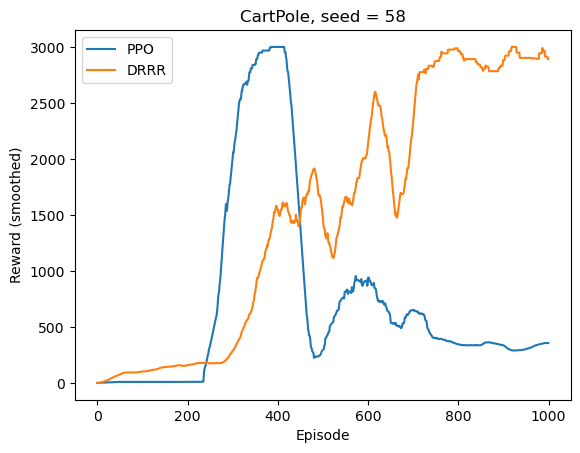

In [131]:
max_episodes = 1000

agent_1 = PPO(ACModel_CartPole, env=env, seed=seed)
num_frames_1, smooth_rs_1 = agent_1.train(max_episodes, nonstop=True)
agent_2 = DRRR(ACModel_CartPole, env=env, seed=seed)
num_frames_2, smooth_rs_2, fits_2 = agent_2.train(max_episodes, nonstop=True)

plt.plot(range(len(smooth_rs_1)), smooth_rs_1, label='PPO')
plt.plot(range(len(smooth_rs_2)), smooth_rs_2, label='DRRR')
plt.xlabel('Episode')
plt.ylabel('Reward (smoothed)')
plt.title(f'CartPole, {seed = }')
plt.legend()
plt.show()

In [110]:
r_ppo = render(env, agent_1, 'cartpole_ppo.mp4')
r_drrr = render(env, agent_2, 'cartpole_drrr.mp4', max_steps=100000)
print(f'{r_ppo = }, {r_drrr = }')

  0%|          | 0/100000 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


  0%|          | 0/100000 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


r_ppo = 5126.0, r_drrr = 100000.0
